<a href="https://colab.research.google.com/github/mknadeer/tesorflow/blob/master/plantdisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
 !pip install tensorflow-gpu==2.0

In [0]:
!pip install 'tensorflow-hub == 0.5' 

  Using cached https://files.pythonhosted.org/packages/b5/be/f18c352d84382d9c795a0f37eaf16d42ace7d161fbb0ad20bdcd5e550015/tensorflow_hub-0.5.0-py2.py3-none-any.whl
  Found existing installation: tensorflow-hub 0.8.0
    Uninstalling tensorflow-hub-0.8.0:
      Successfully uninstalled tensorflow-hub-0.8.0


In [0]:
pip install --upgrade tensorflow-hub

  Using cached https://files.pythonhosted.org/packages/fb/9d/d5772f94e31431cdb56a8bb2c34d8839bb7d7621f2a5959f4ef43207d7ac/tensorflow_hub-0.8.0-py2.py3-none-any.whl
  Found existing installation: tensorflow-hub 0.5.0
    Uninstalling tensorflow-hub-0.5.0:
      Successfully uninstalled tensorflow-hub-0.5.0


In [0]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub

In [0]:
!pwd

/content


In [0]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!ls "/content/gdrive/My Drive"

 classifier.h5	 classifier.tfl    'Getting started.pdf'
 classifier.pt	'Colab Notebooks'   plantdiseasedataset.zip


In [0]:
!unzip -q "/content/gdrive/My Drive/plantdiseasedataset.zip"

replace PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace PlantVillage/Pepper__bell___Bacterial_spot/006adb74-934f-448f-a14f-62181742127b___JR_B.Spot 3395.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [0]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((128, 128))
image_size = 0
directory_root = 'plantvillage/'
width=128
height=128
depth=3

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [0]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
               if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Image loading completed


In [0]:
image_size = len(image_list)

In [0]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [0]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [0]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [0]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [0]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [0]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 42, 42, 64)       

In [0]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [0]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/25
73/73 [==============================] - 13s 174ms/step - loss: 0.2114 - accuracy: 0.9340 - val_loss: 0.8215 - val_accuracy: 0.8764
Epoch 2/25
73/73 [==============================] - 10s 136ms/step - loss: 0.1546 - accuracy: 0.9479 - val_loss: 1.0424 - val_accuracy: 0.8764
Epoch 3/25
73/73 [==============================] - 10s 137ms/step - loss: 0.1436 - accuracy: 0.9501 - val_loss: 0.9475 - val_accuracy: 0.8766
Epoch 4/25
73/73 [==============================] - 10s 139ms/step - loss: 0.1264 - accuracy: 0.9564 - val_loss: 1.4620 - val_accuracy: 0.8757
Epoch 5/25
73/73 [==============================] - 10s 138ms/step - loss: 0.1103 - accuracy: 0.9604 - val_loss: 1.1394 - val_accuracy: 0.8777
Epoch 6/25
73/73 [==============================] - 10s 136ms/step - loss: 0.1063 - accuracy: 0.9619 - val_loss: 0.5185 - val_accuracy: 0.8985
Epoch 7/25
73/73 [==============================] - 10s 138ms/step - loss: 0.0927 - accuracy: 0.9655 - val_loss: 0.3903 - val_accuracy: 0.9149

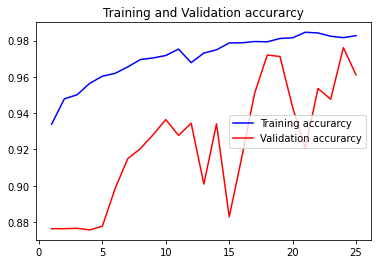

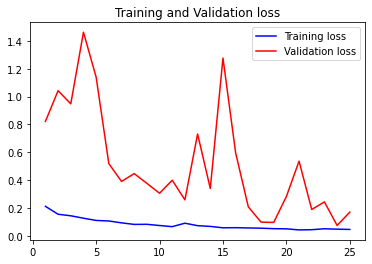

In [0]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
#Train and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accurarcy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [0]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
591/591 [==============================] - 1s 1ms/step
Test Accuracy: 96.10828161239624


In [0]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...


In [0]:
from keras.models import load_model
model.save('classifier.h5')

In [0]:
from keras.models import load_model
model=load_model('classifier.h5')

In [0]:
ls

classifier.h5  converted_model.tflite  label_transform.pkl  PlantVillage/
cnn_model.pkl  gdrive/                 plantvillage/        sample_data/


In [0]:
!pwd

/content


In [0]:
ls /content/gdrive/My\ Drive/

 classifier.h5   classifier.tfl     'Getting started.pdf'
 classifier.pt  'Colab Notebooks'/   plantdiseasedataset.zip


In [0]:
import tensorflow as tf

model = tf.keras.models.load_model('classifier.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

53624300

In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

In [0]:
ls

classifier.h5  converted_model.tflite  label_transform.pkl  PlantVillage/
cnn_model.pkl  gdrive/                 plantvillage/        sample_data/


In [0]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)

Quantized model size = 13112KBs,


In [0]:
# Save the quantized model to file to the Downloads directory
f = open('mnist.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

# Download the digit classification model
from google.colab import files
files.download('mnist.tflite')

print('`mnist.tflite` has been downloaded')

`mnist.tflite` has been downloaded
